In [140]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.lines as mlines

In [166]:
df = pd.read_csv("../data/hr_extended.csv")

print "total number of lines =", len(df)

total number of lines = 21030


In [64]:
COORDS = {
    "00-17-0d-00-00-38-06-c9": [48.84175, 2.38414],
    "00-17-0d-00-00-38-00-63": [48.84196, 2.38443],
    "00-17-0d-00-00-38-03-69": [48.842, 2.38438],
    "00-17-0d-00-00-38-03-87": [48.84177, 2.3843],
    "00-17-0d-00-00-38-03-ca": [48.8419, 2.38424],
    "00-17-0d-00-00-38-03-d9": [48.84182, 2.38434],
    "00-17-0d-00-00-38-04-25": [48.84175, 2.3842],
    "00-17-0d-00-00-38-04-3b": [48.84200, 2.3843],
    "00-17-0d-00-00-38-06-6a": [48.84203, 2.38436],
    "00-17-0d-00-00-38-04-35": [48.84201, 2.38445],
    "00-17-0d-00-00-38-06-f0": [48.84191, 2.3844],
    "00-17-0d-00-00-38-05-f1": [48.84167, 2.38424],
    "00-17-0d-00-00-38-06-d5": [48.84171, 2.38427],
    "00-17-0d-00-00-38-03-dd": [48.84186, 2.38437],
    "00-17-0d-00-00-38-06-67": [48.84181, 2.38418],
    "00-17-0d-00-00-38-07-18": [48.84186, 2.38421],
    "00-17-0d-00-00-38-05-da": [48.84202, 2.3845],
    "00-17-0d-00-00-38-05-e9": [48.84193, 2.38433],
    "00-17-0d-00-00-38-06-45": [48.84195, 2.38427],
    "00-17-0d-00-00-38-06-ad": [48.84206, 2.38439],
    "00-17-0d-00-00-38-06-d6": [48.84179, 2.38424],
    "00-17-0d-00-00-38-07-0c": [48.84171, 2.38419]
}
 
AP_lats = [48.84204, 48.842, 48.84193, 48.84185, 48.84185,
           48.84175, 48.84178]
AP_lons = [2.38432, 2.38445, 2.38425, 2.38436, 2.3842, 
           2.38429, 2.38416]

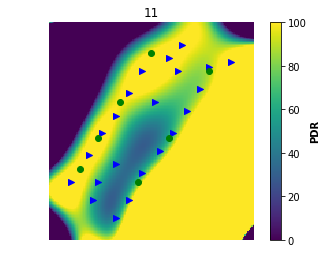

In [137]:
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
#from matplotlib.mlab import griddata
#import scipy.interpolate

for channel, channel_grp in df.groupby("channel"):

    # build data array (TODO clean)
    dat = [[], [], []]
    for mac, mac_group in channel_grp.groupby("mac"):
        if mac in COORDS:
            dat[0].append(COORDS[mac][0])
            dat[1].append(COORDS[mac][1])
            dat[2].append(mac_group.pdr.mean())
    lat = np.array(dat[0])
    lon =  np.array(dat[1])
    rssi =  np.array(dat[2], dtype=float)

    # create the grid
    xlon = np.linspace(min(lon.flat), max(lon.flat), 150)
    xlat = np.linspace(min(lat.flat), max(lat.flat), 150)
    X, Y = np.meshgrid(xlon, xlat)

    Z = interp2d(lon, lat, rssi, kind="cubic")
    # the next few lines are because there seems to be a bug in interp2d
    #  instead one would just want to use   r = interp2d(X.flat, Y.flat) (where X,Y are as below)
    #  but for the version of scipy I'm using ('0.13.3'), this throws an exception.
    r = np.zeros((len(xlon), len(xlat)))
    for i, rlat in enumerate(xlat):
        for j, rlon in enumerate(xlon):
            r[i,j] = Z(rlon, rlat)

    # calculate heatmap boundaries
    extent = [X.min()-0.00005, X.max()+0.00005,
              Y.min()-0.00005, Y.max()+0.00005]

    # display heatmap
    plt.imshow(r, origin="lower", extent=extent,
               alpha=1, vmin=0, vmax=100
               )

    cb = plt.colorbar()
    cb.set_label(label='PDR', weight='bold')

    # show the motes
    plt.scatter(lon.flat, lat.flat, color='b', marker=">")

    # show the ap
    plt.scatter(AP_lons, AP_lats, color='g')

    plt.axis('off')
    plt.xlim([X.min()-0.00005, X.max()+0.00005])
    plt.ylim([Y.min()-0.00005, Y.max()+0.00005])
    plt.title(channel)
    plt.show()
    break

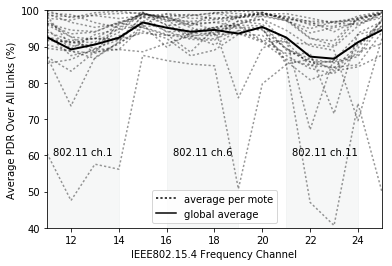

In [165]:
for mote, grp_mote in df.groupby("mac"):
    grp_chan = grp_mote.groupby("channel")
    plt.plot(grp_chan["pdr"].mean(), alpha=0.4, linestyle=":", c='k')

plt.grid()
plt.ylim(40, 100)

# average
df.groupby("channel")["pdr"].mean().plot(alpha=1, label="avg",
                                         style='k', linewidth=2)

# legend
avg_per_mote = mlines.Line2D([], [], color='k', linestyle=':',
                          markersize=15, label='average per mote')
global_avg = mlines.Line2D([], [], color='k',
                          markersize=15, label='global average')
plt.legend(handles=[avg_per_mote, global_avg])

# 802.11 bands
plt.fill_between([11,14], 0, 100, color='#d5dbdb', alpha=0.2)
plt.fill_between([16,19], 0, 100, color='#d5dbdb', alpha=0.2)
plt.fill_between([21,24], 0, 100, color='#d5dbdb', alpha=0.2)
plt.text(11.25, 60, "802.11 ch.1")
plt.text(16.25, 60, "802.11 ch.6")
plt.text(21.25, 60, "802.11 ch.11")

# label & legend
plt.ylabel("Average PDR Over All Links (%)")
plt.xlabel("IEEE802.15.4 Frequency Channel")

#plt.show()
plt.savefig("../figures/heatmap.png", format='png')